In [20]:
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report,roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression


In [5]:
STOPWORDS = set(stopwords.words('english'))

In [7]:
def clean(data):
    from nltk.stem.snowball import SnowballStemmer
    
    stemmer = SnowballStemmer("english")
    data=data.lower()
    data = re.sub('\[.*?\]','',data)
    data = re.sub("\\W", " ", data)
    data = re.sub('https?://\S+|www\.\S+', '', data)
    data = re.sub('<.*?>+', '', data)
    data = re.sub('[%s]' % re.escape(string.punctuation), '', data)
    data = re.sub('\n', '', data)
    data = re.sub('\w*\d\w*', '', data)
    data = ' '.join(stemmer.stem(word) for word in data.split() if word not in STOPWORDS)
    return data

In [9]:
politifact = pd.read_json(r'./data/politifact.json')
snopes = pd.read_json(r'./data/snopes.json')
poli_cols = politifact.columns.to_list()
snopes_col = snopes.columns.to_list()

In [11]:
# Merge two tables and drop the nulls

temp = poli_cols+snopes_col
temp_set = set(temp)
data_cols = ['claim','doc','topic','label']
df = pd.concat([politifact[data_cols],snopes[data_cols]], ignore_index=True)
df = df.sample(frac=1, ignore_index=True)
df =df.dropna(subset=['doc','claim','label'])

In [13]:
df['new_topic']=[' '.join(y) for y in (x for x in df['topic'])]

In [15]:
df['body'] = df['new_topic']+' '+df['claim']+df['doc']

In [17]:
%%timeit

df['body'] = df['body'].apply(clean)

2min 11s ± 73.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [3]:
df=pd.read_csv(r'./data/parsed_data.csv')

In [6]:
df['label'] = df['label'].apply(lambda x: x.lower())

true_labels = ['correct attribution','mostly true','mostly-true', 'true',]
false_labels = ['false','mostly false','pants-fire',]
neutral_labels = ['barely-true',
                  'full-flop',
                  'half-flip',
                  'half-true', 
                  'half-true',
                  'labeled satire',
                  'legend',
                  'lost legend',
                  'misattributed',
                  'miscaptioned',
                  'mixture',
                  'outdated',
                  'no-flip',
                  'research in progress',
                  'scam',
                  'unproven'
                 ]
temp=[]
for index in range(len(df)):
    if df['label'][index] in true_labels:
        temp.append(0)
    elif df['label'][index] in false_labels:
        temp.append(1)
    else:
        temp.append(2)
        
df['new_label']=temp

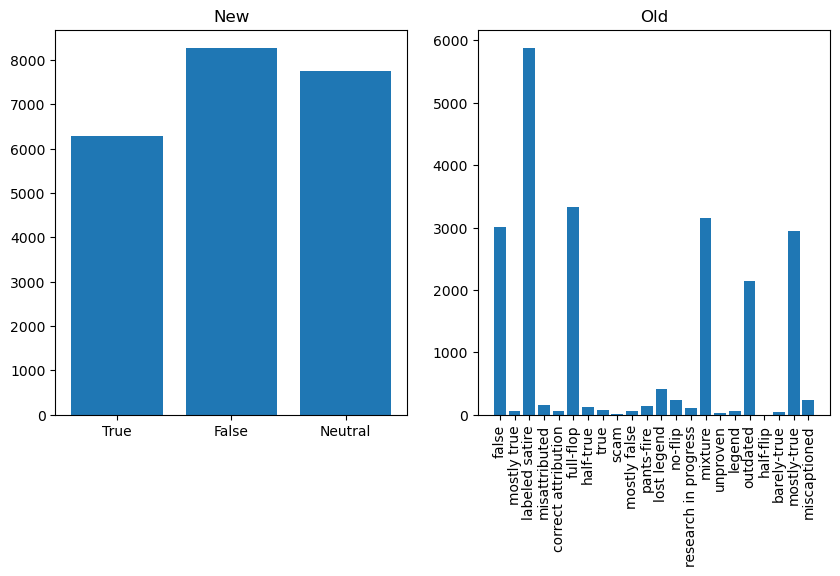

In [7]:
%matplotlib inline

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10, 5))

ld = df.groupby(by='label').size()
new_ld = df.groupby(by='new_label').size()



ax2.bar(list(set(df['label'].tolist())), ld)
ax2.set_title('Old')


ax1.bar(['True','False','Neutral'], new_ld)
ax1.set_title('New')


plt.xticks(rotation='vertical')
plt.show()

In [8]:
# splitting train and test data
x=df['body']

x_train, x_test, y_train, y_test = train_test_split(df['body'],df['new_label'],test_size = 0.20)#, random_state = 42)

In [9]:
# vectorizing the body column using tfidf method
tfidf_vectorizer = TfidfVectorizer()
final_x_train = tfidf_vectorizer.fit_transform(x_train)
final_x_test = tfidf_vectorizer.transform(x_test)

In [10]:
# training logestic Regression model
logestic_r = LogisticRegression(multi_class='multinomial', solver='newton-cg')
logestic_r.fit(final_x_train,y_train)

LogisticRegression(multi_class='multinomial', solver='newton-cg')

In [15]:
# predicting values for test data
lr_pred = logestic_r.predict(final_x_test)

In [17]:
logestic_r.score(final_x_test,y_test)

0.6376681614349776

In [19]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print("Logistic Regression Precision:", precision_score(y_test, lr_pred, average='macro'))
print("Logistic Regression Recall:", recall_score(y_test, lr_pred, average='macro'))
print("Logistic Regression F1 Score:", f1_score(y_test, lr_pred, average='macro'))

Logistic Regression Accuracy: 0.6376681614349776
Logistic Regression Precision: 0.6370155584038587
Logistic Regression Recall: 0.6323841171222987
Logistic Regression F1 Score: 0.6341115576513586


In [23]:
# Confusion matrix
y_test_binarized = label_binarize(y_test, classes=[0,1,2])
cm = confusion_matrix(y_test_binarized.argmax(axis=1), lr_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 719  164  371]
 [ 137 1155  345]
 [ 301  298  970]]


In [24]:
# Classification report
print("Classification Report:") 
print(classification_report(y_test, lr_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.57      0.60      1254
           1       0.71      0.71      0.71      1637
           2       0.58      0.62      0.60      1569

    accuracy                           0.64      4460
   macro avg       0.64      0.63      0.63      4460
weighted avg       0.64      0.64      0.64      4460



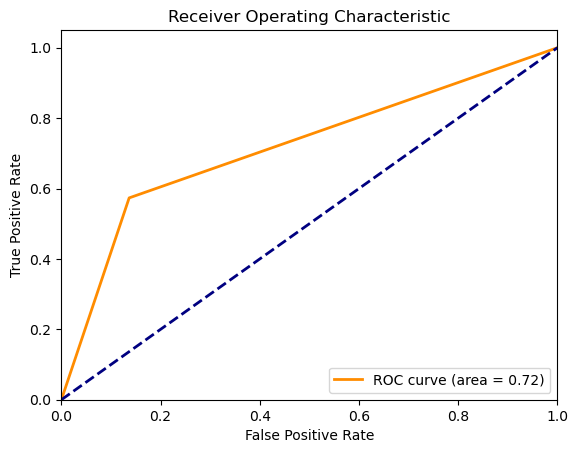

In [26]:
# ROC Curve
lb = LabelBinarizer()
lb.fit(y_test)
y_t = lb.transform(y_test)
e_pred = lb.transform(lr_pred)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(lb.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(y_t[:, i], e_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

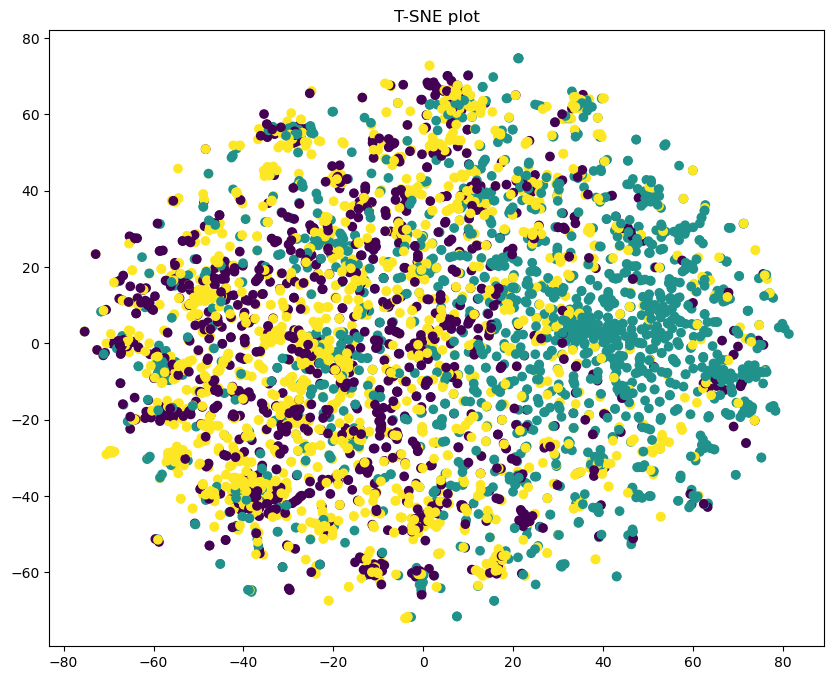

In [27]:
# T-SNE plot
tsne = TSNE(n_components=2, init="random")
X_tsne = tsne.fit_transform(final_x_test)

plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=lr_pred)
plt.title('T-SNE plot')
plt.show()